In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.impute import SimpleImputer
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, recall_score,roc_auc_score
import optuna
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

In [2]:
test = pd.read_csv('test.csv')
# sample = pd.read_csv('sample_submission.csv')
train = pd.read_csv('train.csv')

In [3]:
train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [4]:
comb=pd.concat([train,test])

In [5]:
comb.isna().sum()

PassengerId        0
HomePlanet       288
CryoSleep        310
Cabin            299
Destination      274
Age              270
VIP              296
RoomService      263
FoodCourt        289
ShoppingMall     306
Spa              284
VRDeck           268
Name             294
Transported     4277
dtype: int64

In [6]:
Expenses_columns = ['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck']
comb.loc[:,Expenses_columns]=comb.apply(lambda x: 0 if x.CryoSleep == True else x,axis =1)

In [7]:
comb["in"] = comb["Spa"] + comb["VRDeck"] + comb["RoomService"]

comb["out"] =  comb['FoodCourt'] + comb['ShoppingMall'] 


In [8]:
comb['Expenses'] = comb.loc[:,Expenses_columns].sum(axis=1)

In [9]:
comb.loc[:,['CryoSleep']]=comb.apply(lambda x: True if x.Expenses == 0 and pd.isna(x.CryoSleep) else x,axis =1)

In [10]:
comb.Name = comb.Name.fillna('x x')

In [11]:
comb.loc[:,['Room']] = comb.PassengerId.apply(lambda x: x[0:4] )
guide_VIP=comb.loc[:,['Room','VIP']].dropna().drop_duplicates('Room')
guide_Cabin=comb.loc[:,['Room','Cabin']].dropna().drop_duplicates('Room')
guide_HomePlanet=comb.loc[:,['Room','HomePlanet']].dropna().drop_duplicates('Room')
guide_Destination=comb.loc[:,['Room','Destination']].dropna().drop_duplicates('Room')
comb=pd.merge(comb,guide_Cabin,how="left",on='Room',suffixes=('','_y'))
comb=pd.merge(comb,guide_VIP,how="left",on='Room',suffixes=('','_y'))
comb=pd.merge(comb,guide_HomePlanet,how="left",on='Room',suffixes=('','_y'))
comb=pd.merge(comb,guide_Destination,how="left",on='Room',suffixes=('','_y'))

In [12]:
comb.loc[:,['VIP']]=comb.apply(lambda x: x.VIP_y if pd.isna(x.VIP) else x,axis=1)
comb.loc[:,['Cabin']]=comb.apply(lambda x:  x.Cabin_y if pd.isna(x.Cabin) else x,axis=1)
comb.loc[:,['HomePlanet']]=comb.apply(lambda x:  x.HomePlanet_y if pd.isna(x.HomePlanet) else x,axis=1)
comb.loc[:,['Destination']]=comb.apply(lambda x:  x.Destination_y if pd.isna(x.Destination) else x,axis=1)

In [13]:
comb.loc[:,['Cabin_1']] = comb.Cabin.str.split("/",expand=True).iloc[:,0]
comb.loc[:,['Cabin_2']] = comb.Cabin.str.split("/",expand=True).iloc[:,1]
comb.loc[:,['Cabin_3']] = comb.Cabin.str.split("/",expand=True).iloc[:,2]

In [14]:
num_cols = ['ShoppingMall','FoodCourt','RoomService','Spa','VRDeck','Expenses','Age',"in","out"]
cat_cols = ['CryoSleep','Cabin_1','Cabin_3','VIP','HomePlanet','Destination']
transported=['Transported']
comb = comb[num_cols+cat_cols+transported].copy()

In [15]:
nums=list(comb.select_dtypes(include="number"))

In [16]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import ExtraTreesRegressor
imp_missforest = IterativeImputer(
    estimator=ExtraTreesRegressor(),
    max_iter=30
).set_output(transform="pandas")
imp_missforest.fit(comb[nums])

c:\Users\oskar\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


IterativeImputer(estimator=ExtraTreesRegressor(), max_iter=30)

In [17]:
comb[nums] = imp_missforest.transform(comb[nums])

In [18]:
cat_cols = ['CryoSleep','Cabin_1','Cabin_3','VIP','HomePlanet','Destination']
cat_imp = SimpleImputer(strategy='most_frequent')
comb[cat_cols] = cat_imp.fit_transform(comb[cat_cols])
comb.Cabin_3=comb.Cabin_3.fillna("P")

In [19]:
num_cols = ['ShoppingMall','FoodCourt','RoomService','Spa','VRDeck','Expenses','Age',"in","out"]
cat_cols = ['CryoSleep','Cabin_1','Cabin_3','VIP','HomePlanet','Destination']
transported=['Transported']
comb = comb[num_cols+cat_cols+transported].copy()

In [20]:
comb.CryoSleep = comb.CryoSleep.astype(int)

In [21]:
train = comb[comb['Transported'].notnull()].copy()
train.Transported =train.Transported.astype('int')
test = comb[comb['Transported'].isnull()].drop("Transported",axis=1)

In [22]:
train.head()

,ShoppingMall,FoodCourt,RoomService,Spa,VRDeck,Expenses,Age,in,out,CryoSleep,Cabin_1,Cabin_3,VIP,HomePlanet,Destination,Transported
0,0.0,0.0,0.0,0.0,0.0,0.0,39.0,0.0,0.0,0,B,P,False,Europa,TRAPPIST-1e,0
1,25.0,9.0,109.0,549.0,44.0,736.0,24.0,702.0,34.0,0,F,S,False,Earth,TRAPPIST-1e,1
2,0.0,3576.0,43.0,6715.0,49.0,10383.0,58.0,6807.0,3576.0,0,A,S,True,Europa,TRAPPIST-1e,0
3,371.0,1283.0,0.0,3329.0,193.0,5176.0,33.0,3522.0,1654.0,0,A,S,False,Europa,TRAPPIST-1e,0
4,151.0,70.0,303.0,565.0,2.0,1091.0,16.0,870.0,221.0,0,F,S,False,Earth,TRAPPIST-1e,1


In [23]:
pd.crosstab(train.VIP,train.Transported)

Transported,0,1
VIP,,
False,4192,4302
True,123,76


In [24]:
train.drop("VIP",axis=1,inplace=True)

In [25]:
columns  = train.columns
nunique = pd.DataFrame(train[columns].nunique())
nunique.style.background_gradient(cmap="turbo")

,0
ShoppingMall,1221
FoodCourt,1615
RoomService,1377
Spa,1438
VRDeck,1408
Expenses,2336
Age,167
in,2580
out,2158
CryoSleep,2


In [26]:
fig = px.pie(train, names='Transported', title='Transported Pie Chart')
fig.show()

In [27]:
cat_cols = ['CryoSleep', 'Cabin_1', 'Cabin_3','HomePlanet', 'Destination']

In [28]:
train

,ShoppingMall,FoodCourt,RoomService,Spa,VRDeck,Expenses,Age,in,out,CryoSleep,Cabin_1,Cabin_3,HomePlanet,Destination,Transported
0,0.0,0.0,0.0,0.0,0.0,0.0,39.0,0.0,0.0,0,B,P,Europa,TRAPPIST-1e,0
1,25.0,9.0,109.0,549.0,44.0,736.0,24.0,702.0,34.0,0,F,S,Earth,TRAPPIST-1e,1
2,0.0,3576.0,43.0,6715.0,49.0,10383.0,58.0,6807.0,3576.0,0,A,S,Europa,TRAPPIST-1e,0
3,371.0,1283.0,0.0,3329.0,193.0,5176.0,33.0,3522.0,1654.0,0,A,S,Europa,TRAPPIST-1e,0
4,151.0,70.0,303.0,565.0,2.0,1091.0,16.0,870.0,221.0,0,F,S,Earth,TRAPPIST-1e,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,0.0,6819.0,0.0,1643.0,74.0,8536.0,41.0,1717.0,6819.0,0,A,P,Europa,55 Cancri e,0
8689,0.0,0.0,0.0,0.0,0.0,0.0,18.0,0.0,0.0,1,G,S,Earth,PSO J318.5-22,0
8690,1872.0,0.0,0.0,1.0,0.0,1873.0,26.0,1.0,1872.0,0,G,S,Earth,TRAPPIST-1e,1
8691,0.0,1049.0,0.0,353.0,3235.0,4637.0,32.0,3588.0,1049.0,0,E,S,Europa,55 Cancri e,0


In [29]:
for col in cat_cols:
    print(train.groupby(col)[["Transported"]].agg(["mean","count"]))
    print("=======")

          Transported      
                 mean count
CryoSleep                  
0            0.328176  5558
1            0.814673  3135
        Transported      
               mean count
Cabin_1                  
A          0.503817   262
B          0.732412   796
C          0.680683   761
D          0.433265   487
E          0.360452   885
F          0.439519  2910
G          0.516042  2587
T          0.200000     5
        Transported      
               mean count
Cabin_3                  
P          0.451724  4350
S          0.555607  4343
           Transported      
                  mean count
HomePlanet                  
Earth         0.425079  4745
Europa        0.659880  2161
Mars          0.523223  1787
              Transported      
                     mean count
Destination                    
55 Cancri e      0.609796  1817
PSO J318.5-22    0.503731   804
TRAPPIST-1e      0.471838  6072


Cabin_drop: A,D,G,T, Hp:Mars, Dest: PSO J318.5-22,TRAPPIST-1e

In [30]:
train.groupby("Transported")[["Expenses"]].agg(["mean"])

,Expenses
,mean
Transported,
0,2004.149247
1,885.689127


In [31]:
train.groupby("Transported")[["in"]].agg(["mean"])

,in
,mean
Transported,
0,1468.243349
1,195.037586


In [32]:
train.groupby("Transported")[["out"]].agg(["mean"])

,out
,mean
Transported,
0,553.918313
1,698.419961


<Axes: xlabel='HomePlanet', ylabel='Count'>

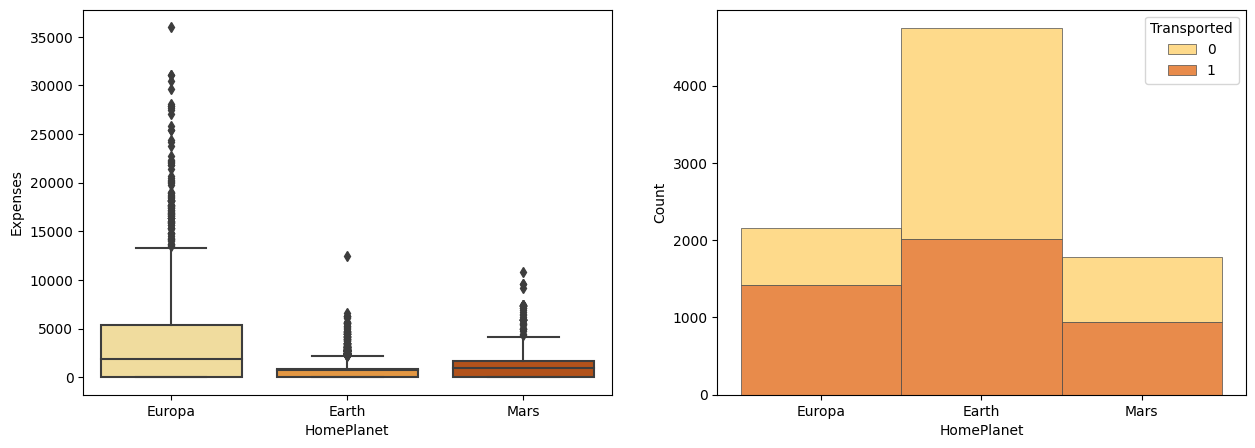

In [30]:
import seaborn as sns
f, ax = plt.subplots(1, 2, figsize = (15,5))
sns.boxplot(x = "HomePlanet", y = "Expenses", palette = "YlOrBr", data = train, ax = ax[0])
sns.histplot(train, x = "HomePlanet", hue = "Transported", multiple = "stack", palette = "YlOrBr", edgecolor = ".3", linewidth = .5, ax = ax[1])


<Axes: xlabel='Destination', ylabel='Count'>

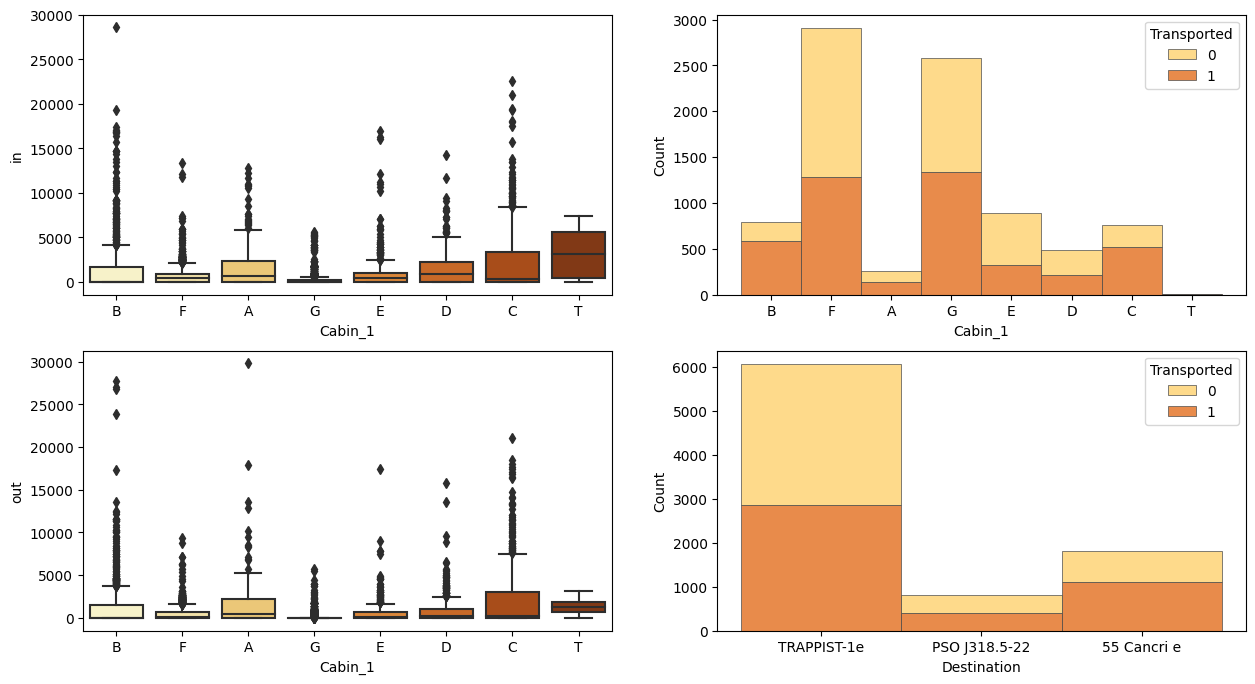

In [31]:
f, ax = plt.subplots(2, 2, figsize = (15,8))
sns.boxplot(x = "Cabin_1", y = "in", palette = "YlOrBr", data = train, ax = ax[0, 0])
sns.histplot(train, x = "Cabin_1", hue = "Transported", multiple = "stack", palette = "YlOrBr", edgecolor = ".3", linewidth = .5, ax = ax[0, 1])
sns.boxplot(x = "Cabin_1", y = "out", palette = "YlOrBr", data = train, ax = ax[1, 0])
sns.histplot(train, x = "Destination", hue = "Transported", multiple = "stack", palette = "YlOrBr", edgecolor = ".3", linewidth = .5, ax = ax[1, 1])


In [32]:
from category_encoders import OneHotEncoder
ohe = OneHotEncoder(
    cols=['Cabin_1','HomePlanet','Destination'],
    use_cat_names=True

)
ohe.fit(train)
train = ohe.transform(train)

In [35]:
train.columns

Index(['ShoppingMall', 'FoodCourt', 'RoomService', 'Spa', 'VRDeck', 'Expenses',
       'Age', 'in', 'out', 'CryoSleep', 'Cabin_1_B', 'Cabin_1_F', 'Cabin_1_A',
       'Cabin_1_G', 'Cabin_1_E', 'Cabin_1_D', 'Cabin_1_C', 'Cabin_1_T',
       'Cabin_3', 'HomePlanet_Europa', 'HomePlanet_Earth', 'HomePlanet_Mars',
       'Destination_TRAPPIST-1e', 'Destination_PSO J318.5-22',
       'Destination_55 Cancri e', 'Transported'],
      dtype='object')

In [ ]:
Cabin_drop: A,D,G,T, Hp:Mars, Dest: PSO J318.5-22,TRAPPIST-1e

In [37]:
train.drop(['Cabin_1_A','Cabin_1_D','Cabin_1_G','Cabin_1_T','HomePlanet_Mars','Destination_PSO J318.5-22','Destination_TRAPPIST-1e'],axis=1,inplace=True)

In [43]:
train.Cabin_3 = train.Cabin_3.map({"P":1,"S":2})

In [49]:
X = train.drop("Transported",axis=1)
y=train["Transported"]
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,stratify=y)

In [51]:
from catboost import CatBoostClassifier, EShapCalcType, EFeaturesSelectionAlgorithm,Pool



train_pool = Pool(X_train, y_train)
test_pool = Pool(X_test, y_test)


    
def select_features(algorithm: EFeaturesSelectionAlgorithm, steps: int = 1):
    print('Algorithm:', algorithm)
    model = CatBoostClassifier(iterations=500, random_seed=0)
    summary = model.select_features(
        train_pool,
        eval_set=test_pool,
        features_for_select=list(range(train_pool.num_col())),
        num_features_to_select=10,
        steps=steps,
        algorithm=algorithm,
        shap_calc_type=EShapCalcType.Regular,
        train_final_model=True,
        logging_level='Silent',
        plot=True
    )
    print('Selected features:', summary['selected_features_names'])
    return summary

adult_shap_summary = select_features(algorithm=EFeaturesSelectionAlgorithm.RecursiveByShapValues, steps=3)

Algorithm: EFeaturesSelectionAlgorithm.RecursiveByShapValues


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

CatBoost is using more CPU RAM (17.9GiB) than the limit (13.9GiB)
CatBoost is using more CPU RAM (17.9GiB) than the limit (13.9GiB)
CatBoost is using more CPU RAM (17.9GiB) than the limit (13.9GiB)
CatBoost is using more CPU RAM (17.9GiB) than the limit (13.9GiB)
CatBoost is using more CPU RAM (17.9GiB) than the limit (13.9GiB)
CatBoost is using more CPU RAM (17.9GiB) than the limit (13.9GiB)
CatBoost is using more CPU RAM (17.9GiB) than the limit (13.9GiB)
CatBoost is using more CPU RAM (17.9GiB) than the limit (13.9GiB)


Selected features: ['Expenses', 'in', 'out', 'CryoSleep', 'Cabin_1_E', 'Cabin_1_C', 'Cabin_3', 'HomePlanet_Europa', 'HomePlanet_Earth', 'Destination_55 Cancri e']


 99%|===================| 3445/3478 [00:29<00:00]          

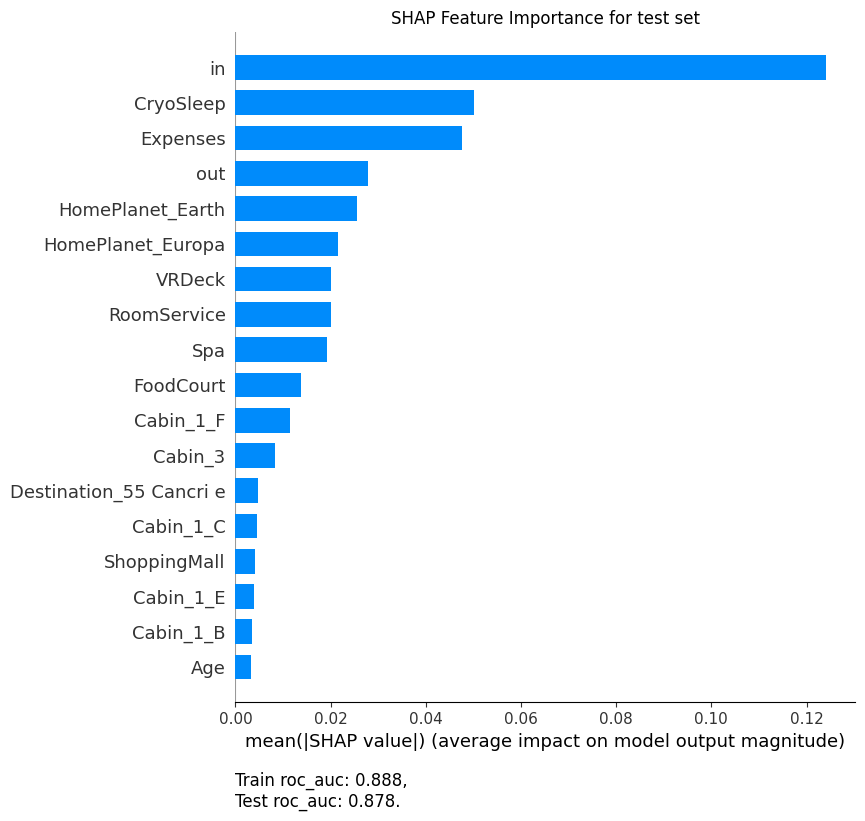

In [52]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from probatus.interpret import ShapModelInterpreter
import warnings
warnings.filterwarnings('ignore')

clf = RandomForestClassifier(n_estimators = 300, random_state=0,max_depth =5)
clf = clf.fit(X_train, y_train)
shap_interpreter = ShapModelInterpreter(clf)
feature_importance = shap_interpreter.fit_compute(X_train, X_test, y_train, y_test, approximate=False)
ax = shap_interpreter.plot('importance')

In [53]:
pd.crosstab(train.Cabin_1_B,train.Transported)

Transported,0,1
Cabin_1_B,,
0,4102,3795
1,213,583


  0%|          | 0/18 [00:00<?, ?it/s]

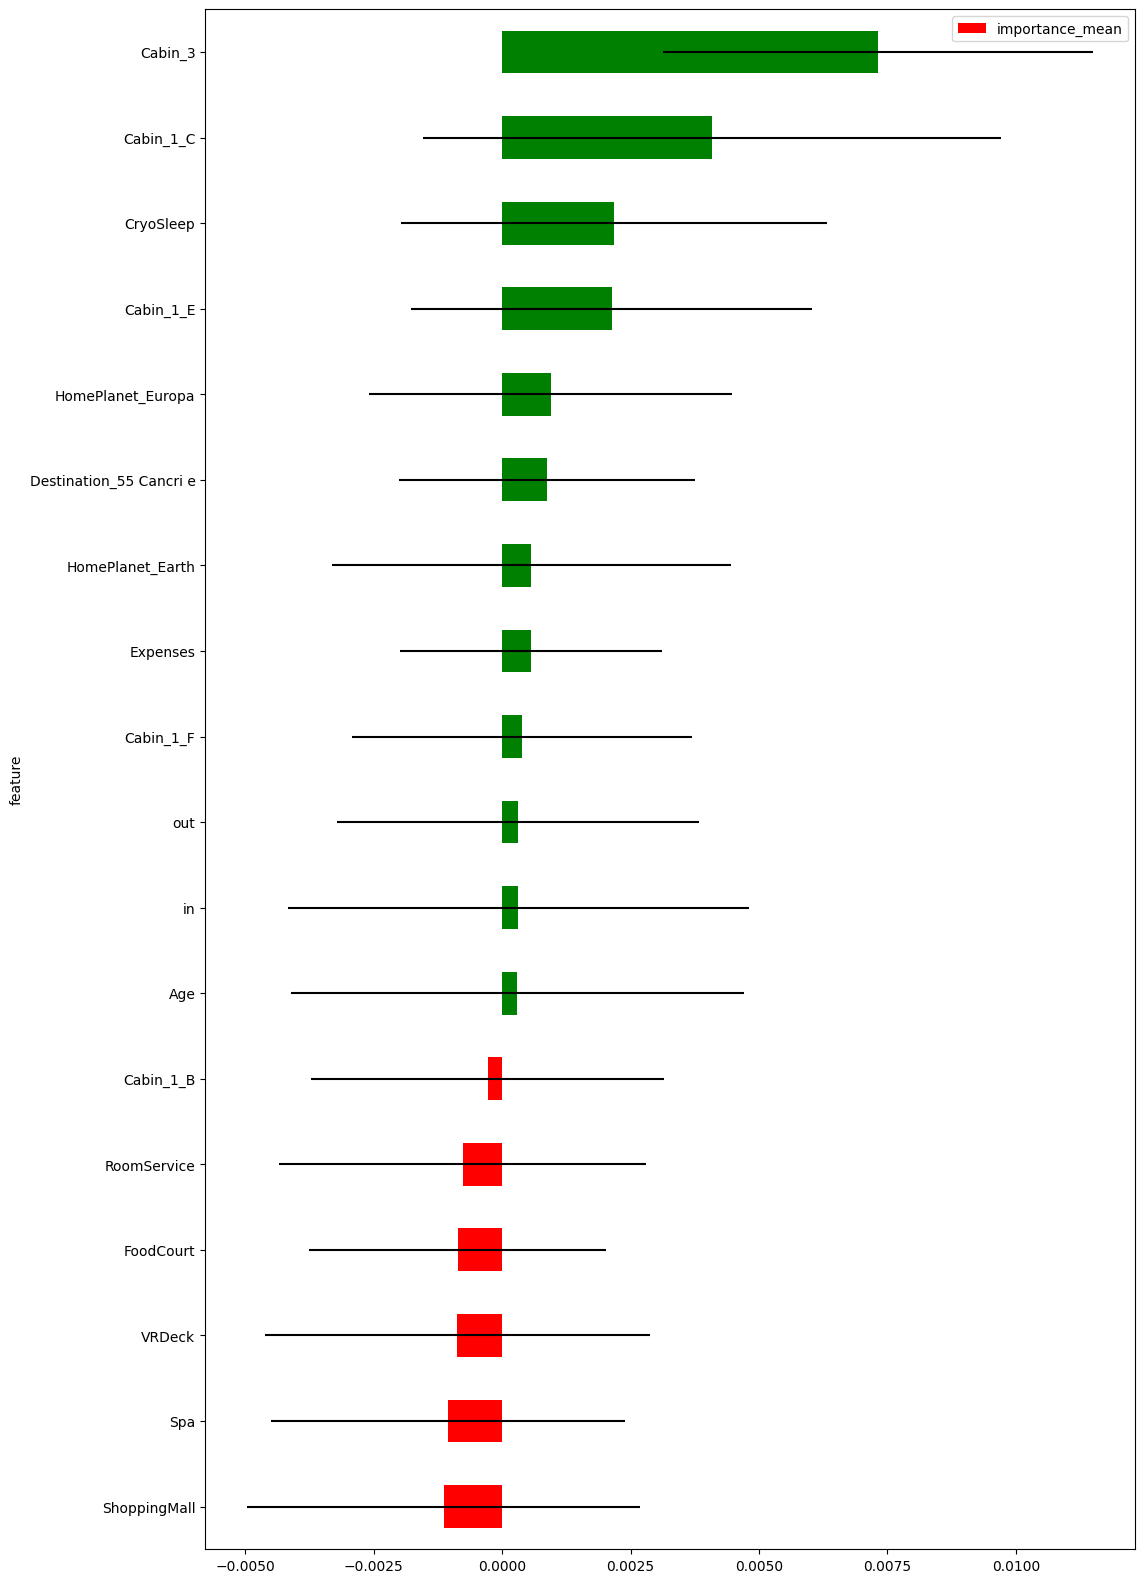

In [54]:
import pandas as pd
from sklearn.model_selection import KFold
from lofo import LOFOImportance, Dataset, plot_importance
%matplotlib inline

# import data
train_df = pd.concat([X_train, y_train],axis=1)

# extract a sample of the data
sample_df = train_df.sample(frac=1, random_state=0)

# define the validation scheme
cv = KFold(n_splits=20, shuffle=False, random_state=None) # Don't shuffle to keep the time split split validation

# define the binary target and the features
dataset = Dataset(df=sample_df, target="Transported", features=[col for col in X_train.columns])

# define the validation scheme and scorer. The default model is LightGBM
lofo_imp = LOFOImportance(dataset, cv=cv, scoring="roc_auc")

# get the mean and standard deviation of the importances in pandas format
importance_df = lofo_imp.get_importance()

# plot the means and standard deviations of the importances
plot_importance(importance_df, figsize=(12, 20))

<Axes: xlabel='0'>

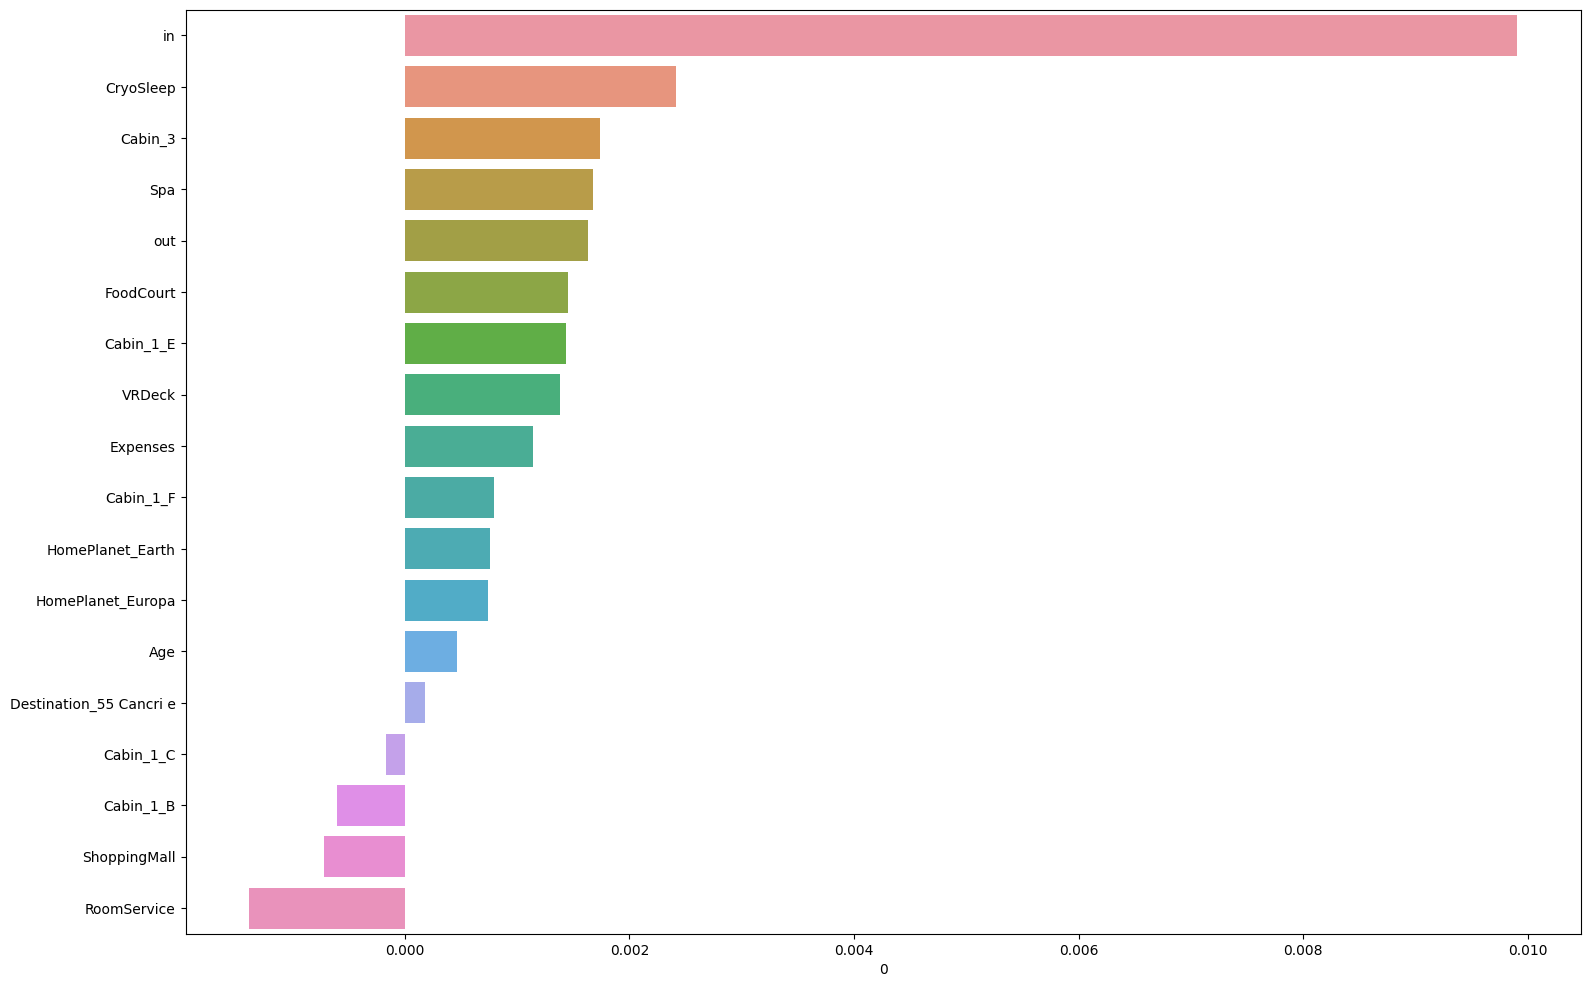

In [56]:
sozluk = {}
rf = RandomForestClassifier(n_estimators =300,random_state=0,max_depth=5)
score1=cross_val_score(rf,X_train,y_train,cv=10,n_jobs=-1,scoring="roc_auc").mean()

for col in X_train.columns:
    X_t2 = X_train.drop(col,axis=1)
    score = cross_val_score(rf,X_t2,y_train,cv=10,n_jobs=-1,scoring="roc_auc").mean()
    sozluk[col] = score1-score
    
seri = pd.Series(sozluk)
seri = pd.DataFrame(seri)
seri=seri.sort_values(by=0,ascending=False)
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(18,12))
sns.barplot(y=seri.index,x=seri[0])

In [57]:
train.columns

Index(['ShoppingMall', 'FoodCourt', 'RoomService', 'Spa', 'VRDeck', 'Expenses',
       'Age', 'in', 'out', 'CryoSleep', 'Cabin_1_B', 'Cabin_1_F', 'Cabin_1_E',
       'Cabin_1_C', 'Cabin_3', 'HomePlanet_Europa', 'HomePlanet_Earth',
       'Destination_55 Cancri e', 'Transported'],
      dtype='object')

In [58]:
train.drop(['ShoppingMall','RoomService','Cabin_1_B', 'Cabin_1_F','Cabin_1_C','Destination_55 Cancri e','Age'],axis=1,inplace=True)

In [59]:
X = train.drop("Transported",axis=1)
y=train["Transported"]
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,stratify=y)

In [63]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
rf= RandomForestClassifier(n_estimators=300,max_depth=5,random_state=0)
sbs = SFS(estimator=rf, 
           k_features=8, 
           forward=False, 
           floating=True, 
           verbose=0,
           scoring='roc_auc',
           cv=20,
           n_jobs=-1)

sbs = sbs.fit(X, y)

pd.DataFrame.from_dict(sbs.get_metric_dict()).T.sort_values('avg_score',ascending=False)

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
10,"(0, 1, 3, 4, 5, 6, 7, 8, 9, 10)","[0.89395188567563, 0.8922395569085065, 0.85046...",0.882053,"(FoodCourt, Spa, Expenses, in, out, CryoSleep,...",0.009351,0.019541,0.004483
9,"(1, 3, 4, 5, 6, 7, 8, 9, 10)","[0.892831473025537, 0.8921127177405718, 0.8475...",0.881705,"(Spa, Expenses, in, out, CryoSleep, Cabin_1_E,...",0.009547,0.019949,0.004577
11,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10)","[0.8936982073397599, 0.8907174868932859, 0.851...",0.88068,"(FoodCourt, Spa, VRDeck, Expenses, in, out, Cr...",0.009171,0.019164,0.004397
8,"(3, 4, 5, 6, 7, 8, 9, 10)","[0.8897344833417893, 0.8887514797902925, 0.849...",0.880655,"(Expenses, in, out, CryoSleep, Cabin_1_E, Cabi...",0.009358,0.019555,0.004486


In [64]:
pd.DataFrame.from_dict(sbs.get_metric_dict()).T.sort_values('avg_score',ascending=False)["feature_idx"].loc[10]

(0, 1, 3, 4, 5, 6, 7, 8, 9, 10)

In [67]:
X=X.iloc[:,[0, 1, 3, 4, 5, 6, 7, 8, 9, 10]]

In [68]:
def objective(trial):
    
    param = { 
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'lambda': trial.suggest_float('lambda', 0, 10.0),
        'alpha': trial.suggest_float('alpha', 0, 10.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1,1.0),
        'subsample': trial.suggest_float('subsample', 0.2,1.0),
        'learning_rate': trial.suggest_float('learning_rate', 0.0001,0.1),
        'n_estimators': trial.suggest_int('n_estimators', 400,1200),
        'max_depth': trial.suggest_categorical('max_depth', [2,3,4,5,6,7,8,9,10]),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        
        }
    
    xgb = XGBClassifier(**param,tree_method='gpu_hist', gpu_id=0
        )

    score = cross_val_score(xgb, X, y, n_jobs=-1, cv=20,scoring="roc_auc")
    roc_auc = score.mean()
    return roc_auc

study = optuna.create_study(pruner=optuna.pruners.HyperbandPruner(),
                                direction='maximize')
study.optimize(objective, n_trials=70)

[I 2023-06-20 15:43:09,635] A new study created in memory with name: no-name-03adb117-ee0c-4f9e-bc8b-b902e4bc8908
[I 2023-06-20 15:43:36,718] Trial 0 finished with value: 0.8830657088906779 and parameters: {'lambda': 8.91952324160528, 'alpha': 4.556312670627674, 'colsample_bytree': 0.9649745362936162, 'subsample': 0.316951099485088, 'learning_rate': 0.03581100821819097, 'n_estimators': 545, 'max_depth': 3, 'min_child_weight': 8}. Best is trial 0 with value: 0.8830657088906779.
[I 2023-06-20 15:44:17,482] Trial 1 finished with value: 0.8736146590627032 and parameters: {'lambda': 2.67664759815141, 'alpha': 6.275077229157089, 'colsample_bytree': 0.18336722305326947, 'subsample': 0.4127811378715765, 'learning_rate': 0.06993293942565167, 'n_estimators': 842, 'max_depth': 6, 'min_child_weight': 8}. Best is trial 0 with value: 0.8830657088906779.
[I 2023-06-20 15:45:19,280] Trial 2 finished with value: 0.8847218824599535 and parameters: {'lambda': 8.173235409034415, 'alpha': 1.454109944462415

In [69]:
trial = study.best_trial
print(trial.value)
print(trial.params)

0.8883940795164044
{'lambda': 0.30415126493855826, 'alpha': 6.741191750660258, 'colsample_bytree': 0.3245021397382939, 'subsample': 0.8827810542200667, 'learning_rate': 0.06236297071436684, 'n_estimators': 924, 'max_depth': 5, 'min_child_weight': 2}


In [71]:
xgb = XGBClassifier(**trial.params)
cross_val_score(xgb, X, y, n_jobs=-1, cv=20,scoring="roc_auc").mean()

0.8879344978713283